In [1]:
# 필요한 라이브러리랑 프레임 워크 불러오기
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from tensorflow.keras import backend as K

model = load_model('model_by.h5')

# yolo 모델에서 정의한 (416, 416) 형식으로 이미지를 받게끔한다.
input_w, input_h = 416, 416

2022-03-21 07:35:06.316512: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox: # 바운드 박스 정의
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
        
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        
        return self.score


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [3]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # 0 and 1 is row and column 13*13
    nb_box = 3 # 3 anchor boxes
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) #13*13*3 ,-1
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # 중앙 위치
            y = (row + y) / grid_h # 중앙 위치
            w = anchors[2 * b + 0] * np.exp(w) / net_w # 이미지 너비값
            h = anchors[2 * b + 1] * np.exp(h) / net_h # 이미지 높이값
            # 위에 만들었던 클래스 확률 계산
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [4]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

# 교차점 박스   
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin  
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    #Union(A,B) = A + B - Inter(A,B)
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [5]:
def do_nms(boxes, nms_thresh):    #boxes from correct_yolo_boxes and  decode_netout
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [6]:
# 이미지를 픽셀화해서 불러오는 함수
def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    # 이미지 사이즈 재조정
    image = load_img(filename, target_size=shape)
    # 넘파이의 Array로 변환
    image = img_to_array(image)
    # [0, 1]로 픽셀화
    image = image.astype('float32')
    image /= 255.0  # 픽셀값을 0-255로 나눈다. 이미지가 0-255 범위에 있기떄문이다.
    image = expand_dims(image, 0)
    return image, width, height

In [7]:
# 임계값 이상의 모든 결과를 얻을 수 있도록 하는 함수
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        # 가능한 모든 레이블
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    
    return v_boxes, v_labels, v_scores

In [8]:
# 모든 결과를 그리는 박스 정의
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    img = cv2.imread(filename)
    for i in range(len(v_boxes)):
        # 각 경계 박스에 좌표 찾기
        box = v_boxes[i]
        # 좌표값 가져오기
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        start_point = (x1, y1) 
        # 종료 좌표로 박스의 오른쪽 하단에 나타내기
        end_point = (x2, y2) 
        # BGR형태의 붉은 색으로 박스칸 표시
        color = (0, 0, 255) 
        # 선두께 조정 2px
        thickness = 2
        # 폰트 정의
        font = cv2.FONT_HERSHEY_PLAIN 
        # 폰트크기 정의
        fontScale = 1.5
        # shape 정의
        img = cv2.rectangle(img, start_point, end_point, color, thickness) 
        # 왼쪽 상단 모서리에 텍스트 및 점수 표시
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        img = cv2.putText(img, label, (x1,y1), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    # 이미지 plot 표시하고, 해당 파일 저장시키기
    output = "outputs/"+filename.rsplit("/")[1].rsplit(".")[0]+'_yolov3.jpg'
    cv2.imwrite(output,img)
    cv2.imshow("yolov3",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [9]:
def img_blur(filename, v_boxes, v_labels, v_scores):
    img = cv2.imread(filename)
    rows, cols = img.shape[0], img.shape[1]
    blurred_img = cv2.GaussianBlur(img, (201, 201), 0)
    mask = np.zeros((rows, cols, 3), dtype=np.uint8)
    
    for i in range(len(v_boxes)):
        if (not v_boxes):
            x1,y1 = 0,0
            x2,y2 = 0,0
        else:
            box = v_boxes[i]
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        mask = cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), -1)
    out = np.where(mask==np.array([255, 255, 255]), img, blurred_img)
    output = "outputs/"+filename.rsplit("/")[1].rsplit(".")[0]+"_blur.jpg"
    cv2.imwrite(output, out) 
    cv2.imshow("img_blur",out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [10]:
# 앵커값 정의
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]  

# 감지된 객체에 대한 확률 임계값을 정의
class_threshold = 0.6

labels = ["face"]


In [11]:
# 추가적으로 필요한 라이브러리 불러오기
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# 이미지 어떤거 불러올건지 정의하기
photo_filename = 'samples/joli.jpeg'
input_w, input_h = 416, 416
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print(image.shape)

(1, 416, 416, 3)


In [12]:
# 만들었던 model 불러오기
model = load_model('model.h5')
yhat = model.predict(image)
# 배열 목록의 모양 요약하기

print([a.shape for a in yhat])
# 앵커박스 3개랑 클래스 1개
# 계산방식 : 13*13*3*6 (1+5)  13*13*18

[(1, 13, 13, 18), (1, 26, 26, 18), (1, 52, 52, 18)]


In [13]:
boxes = list()
for i in range(len(yhat)):
    # 신경망 출력을 디코딩하기
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    
# 이미지 모양에 맞게 박스 크기 수정하기
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# 최대가 아닌 박스는 억제시키기
# 0.1이하의 박스는 버리도록 조정 => 얼굴이 아닐 조금의 가능성은 없애기
do_nms(boxes, 0.1)  

# 감지된 객체의 세부 정보 얻기
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


# 찾았다면 해당 파일 표시하기
# 코랩에서는 안되고 주피터만 됨, 코랩에서는 cv.imshow를 cv.im_show로 표시할 것 
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
img_blur(photo_filename, v_boxes, v_labels, v_scores)

face 95.99459171295166


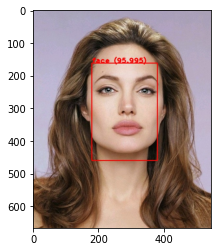

In [14]:
#We can also plot our original photograph and draw the bounding box around each detected object.
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])    
img = pyplot.imread("outputs/"+photo_filename.rsplit("/")[1].rsplit(".")[0]+'_yolov3.jpg')
pyplot.imshow(img)

In [15]:
K.clear_session() 